# Table of contents

- Import required libraries
- Load the 2017 Census Tract dataset
- Data Exploration and Analysis
- Missing value Analysis and Imputation
- Outlier Analysis
- Feature Engineering
- Modeling
- Conclusion

# Assumptions of the Model

It's essential to understand the assumptions of the model before we start building and coding. Each assumption if violated means we may have to take extra steps to improve our model or in some cases dump the model altogether. Here is a list of the assumptions of the model:

 - Regression residuals must be normally distributed.
 - A linear relationship is assumed between the dependent variable and the independent variables.
 - The residuals are homoscedastic and approximately rectangular-shaped.
 - Absence of multicollinearity is expected in the model, meaning that independent variables are not too highly correlated.
 - No Autocorrelation of the residuals.

I will be explaining these assumptions in more detail as we arrive at each of them in the tutorial. At this point, however, we need to have an idea of what they are.

# Section 1: Import our Libraries

The first thing we need to do is import the libraries we will be using in this tutorial. To visualize our data, we will be using matplotlib and seaborn to create heatmaps and a scatter matrix. To build our model, we will be using the sklearn library, and the evaluation will be taking place with the statsmodels library. I've also added a few additional modules to help calculate certain metrics.

In [1]:
###Import Libraries 
### Data handling imports
import pandas as pd
import numpy as np

### Plotting imports
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

%matplotlib inline

from pandas.core.reshape.pivot import pivot_table

# Advanced plotting... Plotly
from plotly import tools
import plotly.offline as py
from plotly.offline import init_notebook_mode, iplot, plot
import plotly.graph_objs as go
init_notebook_mode(connected=True)

# Statistics imports
import scipy, scipy.stats
import statsmodels.api as sm
from statsmodels.stats import diagnostic as diag
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

%matplotlib inline

# df.head() displays all the columns without truncating
pd.set_option('display.max_columns', None)

import warnings
warnings.filterwarnings('ignore')

### Design Settings

Design some python settings 

In [2]:
# Plot bar graphs
def pretty_bar(data, ax, xlabel=None, ylabel=None, title=None, int_text=False):
    
    # Plots the data
    fig = sns.barplot(data.values, data.index, ax=ax)
    
    # Places text for each value in data
    for i, v in enumerate(data.values):
        
        # Decides whether the text should be rounded or left as floats
        if int_text:
            ax.text(0, i, int(v), color='k', fontsize=12)
        else:
            ax.text(0, i, round(v, 3), color='k', fontsize=12)
     
    ### Labels plot
    ylabel != None and fig.set(ylabel=ylabel)
    xlabel != None and fig.set(xlabel=xlabel)
    title != None and fig.set(title=title)

    
### Style Python print statements
class color:
    BOLD = '\033[1m'
    UNDERLINE = '\033[3m'
    END = '\033[0m'

# Section 2: Load the Dataset

After we've loaded our libraries, we can begin the process of importing and exploring our data. I've created an excel file with all the data we will be using in this tutorial. It contains 10 explanatory variables and 1 dependent variable. After we've loaded the data into the data frame, we will need to replace all the .. values with nan as these represent missing values in our dataset.

This dataset was downloaded from the World Bank website; if you would like to visit the site yourself, I encourage you to visit the link provided below. There is a tremendous amount of data available for free, that can be used across a wide range of models.

Link: https://data.worldbank.org/

From here, we will set the index of our data frame using the set_index() function to the Year column. The reasoning behind this is because it will make selecting the data easier. After we've defined the index, we convert the entire data frame to a float data type and then select years 1969 to 2016. These years were selected because they do not contain any missing values.

To make selecting the columns a little easier, we will rename all of our columns. I'll create a dictionary where the keys represent the old column names and the values associated with those keys are the new column names. I'll then call the rename() method and pass through the new columns dictionary.

Finally, I'll check one last time for any missing values using isnull().any(), which will return true for a given column if any values are missing, and then print the head of the data frame.

In [3]:
###Load the Data into Pandas
usa_census = pd.read_csv('OneDrive/Desktop/ProjectITU/Census/2015 and 2017 US census/acs2017_bystates_data_ProjectITU.csv')
usa_census.head()

,TractId,State,County,TotalPop,Men,Women,Hispanic,White,Black,Native,Asian,Pacific,VotingAgeCitizen,Income,IncomeErr,IncomePerCap,IncomePerCapErr,Poverty,ChildPoverty,Professional,Service,Office,Construction,Production,Drive,Carpool,Transit,Walk,OtherTransp,WorkAtHome,MeanCommute,Employed,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment
0,1001020100,Alabama,Autauga County,1845,899,946,2.4,86.3,5.2,0.0,1.2,0.0,1407,67826,14560,33018,6294,10.7,20.8,38.5,15.6,22.8,10.8,12.4,94.2,3.3,0.0,0.5,0.0,2.1,24.5,881,74.2,21.2,4.5,0.0,4.6
1,1001020200,Alabama,Autauga County,2172,1167,1005,1.1,41.6,54.5,0.0,1.0,0.0,1652,41287,3819,18996,2453,22.4,35.8,30.5,24.9,22.9,6.3,15.4,90.5,9.1,0.0,0.0,0.5,0.0,22.2,852,75.9,15.0,9.0,0.0,3.4
2,1001020300,Alabama,Autauga County,3385,1533,1852,8.0,61.4,26.5,0.6,0.7,0.4,2480,46806,9496,21236,2562,14.7,21.1,27.9,19.4,33.3,9.9,9.6,88.3,8.4,0.0,1.0,0.8,1.5,23.1,1482,73.3,21.1,4.8,0.7,4.7
3,1001020400,Alabama,Autauga County,4267,2001,2266,9.6,80.3,7.1,0.5,0.2,0.0,3257,55895,4369,28068,3190,2.3,1.7,29.0,16.6,25.8,9.1,19.5,82.3,11.2,0.0,1.5,2.9,2.1,25.9,1849,75.8,19.7,4.5,0.0,6.1
4,1001020500,Alabama,Autauga County,9965,5054,4911,0.9,77.5,16.4,0.0,3.1,0.0,7229,68143,14424,36905,10706,12.2,17.9,48.8,13.8,20.5,3.5,13.4,86.9,11.2,0.0,0.8,0.3,0.7,21.0,4787,71.4,24.1,4.5,0.0,2.3


In [4]:
usa_census.tail(2)

,TractId,State,County,TotalPop,Men,Women,Hispanic,White,Black,Native,Asian,Pacific,VotingAgeCitizen,Income,IncomeErr,IncomePerCap,IncomePerCapErr,Poverty,ChildPoverty,Professional,Service,Office,Construction,Production,Drive,Carpool,Transit,Walk,OtherTransp,WorkAtHome,MeanCommute,Employed,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment
72882,72153750601,Puerto Rico,Yauco Municipio,4380,1964,2416,100.0,0.0,0.0,0.0,0.0,0.0,3346,18688,4501,8331,1280,50.1,58.0,29.8,20.6,28.8,13.9,6.9,97.1,1.8,1.1,0.0,0.0,0.0,24.1,1062,67.7,30.4,1.9,0.0,29.5
72883,72153750602,Puerto Rico,Yauco Municipio,3001,1343,1658,99.2,0.8,0.0,0.0,0.0,0.0,2641,9458,3332,6251,1683,69.4,72.2,12.4,23.8,19.1,17.8,26.9,79.6,5.6,1.0,4.9,0.0,8.9,21.6,759,75.9,19.1,5.0,0.0,17.9


# Description of Data

Additional detail may be found in the data set page.

- Location: State/County are distinct and define a census region
- Sex:  TotalPop=Men+Women 
- Race: % of TotalPop.  Hispanic+White+Black+Native+Asian+Pacific<=100% 
- Citizen: Number of people who are citizens.  Citizen<=TotalPop 
- Income: Median household income
- IncomeErr: Median household income error
- IncomePerCap: Income per capita
- Poverty: % of TotalPop under poverty level
- ChildPoverty: % of children under poverty level
- Work Class: % of Employed.  Professional+Service+Office+Construction+Production<=100% 
- Transportation: % of Employed?  Drive+Carpool+Transit+Walk+OtherTransp+WorkAtHome<=100% 
- MeanCommute: Average commute time (minutes) of Employed
- Employed: Number of people employed (16+)
- Work Sector: % of Employed.  PrivateWork+PublicWork+SelfEmployed+FamilyWork<=100% 
- Unemployment: % of TotalPop who have filed for unemployement

# Cleaning the Data
Cleaning the data is an essential part of your data organization. Once inspecting your data, you will notice that there will be some data that you don't necessarily need or data that could influenze your numbers and impact your analysis.

For purposes of this tutorial, I will drop all rows that contain null values


In [5]:
usa_census = usa_census.dropna()
usa_census.shape

(72718, 37)

You can see that we have dropped ~1.5K rows.

In [6]:
usa_census = usa_census.drop(columns=['TractId', 'VotingAgeCitizen'])

In [7]:
usa_census = usa_census.dropna()
print("Shape of dataset", usa_census.shape)
print("Columns", usa_census.columns)
usa_census.head()

Shape of dataset (72718, 35)
Columns Index(['State', 'County', 'TotalPop', 'Men', 'Women', 'Hispanic', 'White',
       'Black', 'Native', 'Asian', 'Pacific', 'Income', 'IncomeErr',
       'IncomePerCap', 'IncomePerCapErr', 'Poverty', 'ChildPoverty',
       'Professional', 'Service', 'Office', 'Construction', 'Production',
       'Drive', 'Carpool', 'Transit', 'Walk', 'OtherTransp', 'WorkAtHome',
       'MeanCommute', 'Employed', 'PrivateWork', 'PublicWork', 'SelfEmployed',
       'FamilyWork', 'Unemployment'],
      dtype='object')


,State,County,TotalPop,Men,Women,Hispanic,White,Black,Native,Asian,Pacific,Income,IncomeErr,IncomePerCap,IncomePerCapErr,Poverty,ChildPoverty,Professional,Service,Office,Construction,Production,Drive,Carpool,Transit,Walk,OtherTransp,WorkAtHome,MeanCommute,Employed,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment
0,Alabama,Autauga County,1845,899,946,2.4,86.3,5.2,0.0,1.2,0.0,67826,14560,33018,6294,10.7,20.8,38.5,15.6,22.8,10.8,12.4,94.2,3.3,0.0,0.5,0.0,2.1,24.5,881,74.2,21.2,4.5,0.0,4.6
1,Alabama,Autauga County,2172,1167,1005,1.1,41.6,54.5,0.0,1.0,0.0,41287,3819,18996,2453,22.4,35.8,30.5,24.9,22.9,6.3,15.4,90.5,9.1,0.0,0.0,0.5,0.0,22.2,852,75.9,15.0,9.0,0.0,3.4
2,Alabama,Autauga County,3385,1533,1852,8.0,61.4,26.5,0.6,0.7,0.4,46806,9496,21236,2562,14.7,21.1,27.9,19.4,33.3,9.9,9.6,88.3,8.4,0.0,1.0,0.8,1.5,23.1,1482,73.3,21.1,4.8,0.7,4.7
3,Alabama,Autauga County,4267,2001,2266,9.6,80.3,7.1,0.5,0.2,0.0,55895,4369,28068,3190,2.3,1.7,29.0,16.6,25.8,9.1,19.5,82.3,11.2,0.0,1.5,2.9,2.1,25.9,1849,75.8,19.7,4.5,0.0,6.1
4,Alabama,Autauga County,9965,5054,4911,0.9,77.5,16.4,0.0,3.1,0.0,68143,14424,36905,10706,12.2,17.9,48.8,13.8,20.5,3.5,13.4,86.9,11.2,0.0,0.8,0.3,0.7,21.0,4787,71.4,24.1,4.5,0.0,2.3


In [8]:
### Show unique datas
usa_census["State"].unique()

array(['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California',
       'Colorado', 'Connecticut', 'Delaware', 'District of Columbia',
       'Florida', 'Georgia', 'Hawaii', 'Idaho', 'Illinois', 'Indiana',
       'Iowa', 'Kansas', 'Kentucky', 'Louisiana', 'Maine', 'Maryland',
       'Massachusetts', 'Michigan', 'Minnesota', 'Mississippi',
       'Missouri', 'Montana', 'Nebraska', 'Nevada', 'New Hampshire',
       'New Jersey', 'New Mexico', 'New York', 'North Carolina',
       'North Dakota', 'Ohio', 'Oklahoma', 'Oregon', 'Pennsylvania',
       'Rhode Island', 'South Carolina', 'South Dakota', 'Tennessee',
       'Texas', 'Utah', 'Vermont', 'Virginia', 'Washington',
       'West Virginia', 'Wisconsin', 'Wyoming', 'Puerto Rico'],
      dtype=object)

In [9]:
# get column name and data types to make sure the types are right, results looking good.  
usa_census.dtypes

State               object
County              object
TotalPop             int64
Men                  int64
Women                int64
Hispanic           float64
White              float64
Black              float64
Native             float64
Asian              float64
Pacific            float64
Income               int64
IncomeErr            int64
IncomePerCap         int64
IncomePerCapErr      int64
Poverty            float64
ChildPoverty       float64
Professional       float64
Service            float64
Office             float64
Construction       float64
Production         float64
Drive              float64
Carpool            float64
Transit            float64
Walk               float64
OtherTransp        float64
WorkAtHome         float64
MeanCommute        float64
Employed             int64
PrivateWork        float64
PublicWork         float64
SelfEmployed       float64
FamilyWork         float64
Unemployment       float64
dtype: object

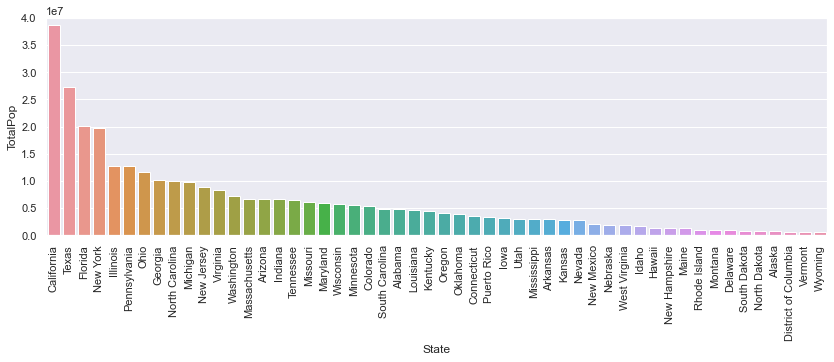

In [10]:
#Lets see how the population looks like on the graph by states 
usastates= usa_census.groupby('State', as_index=False).sum()
usastates= usastates.sort_values('TotalPop', ascending = 0)

#Total population by country looks like below; 

fig, ax = plt.subplots(figsize=(14,4))
fig = sns.barplot(x = usastates['State'], y = usastates['TotalPop'], data=usastates)
fig.axis(ymin=0, ymax=40000000)
plt.xticks(rotation=90)
plt.show()

In [11]:
#We'll select the top 5 states for our analysis to be able to pick a homegenius data. 
# Create a new dataset which contains data of states with top 5 total population

ca = usa_census.groupby('State').get_group('California')
tx = usa_census.groupby('State').get_group('Texas')
fl = usa_census.groupby('State').get_group('Florida')
ny = usa_census.groupby('State').get_group('New York')
il = usa_census.groupby('State').get_group('Illinois')
pn = usa_census.groupby('State').get_group('Pennsylvania')
oh = usa_census.groupby('State').get_group('Ohio')
go = usa_census.groupby('State').get_group('Georgia')
nc = usa_census.groupby('State').get_group('North Carolina')
mg = usa_census.groupby('State').get_group('Michigan')
nj = usa_census.groupby('State').get_group('New Jersey')
vn = usa_census.groupby('State').get_group('Virginia')
wg = usa_census.groupby('State').get_group('Washington')
mt = usa_census.groupby('State').get_group('Massachusetts')
ar = usa_census.groupby('State').get_group('Arizona')
ind = usa_census.groupby('State').get_group('Indiana')
tn = usa_census.groupby('State').get_group('Tennessee')
ms = usa_census.groupby('State').get_group('Missouri')
my = usa_census.groupby('State').get_group('Maryland')
wc = usa_census.groupby('State').get_group('Wisconsin')

usatop20states = pd.concat([ca, tx, fl, ny, il, pn, oh, go, nc, mg, nj, vn, wg, mt, ar, ind, tn, ms, my, wc])
usatop20states.head()

,State,County,TotalPop,Men,Women,Hispanic,White,Black,Native,Asian,Pacific,Income,IncomeErr,IncomePerCap,IncomePerCapErr,Poverty,ChildPoverty,Professional,Service,Office,Construction,Production,Drive,Carpool,Transit,Walk,OtherTransp,WorkAtHome,MeanCommute,Employed,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment
3533,California,Alameda County,2991,1442,1549,3.8,69.2,2.8,0.0,16.2,0.0,208393,46352,115773,19839,4.2,8.4,72.4,8.1,15.6,1.5,2.5,52.4,10.6,14.3,0.5,2.2,20.0,34.8,1543,80.6,6.6,12.8,0.0,4.0
3534,California,Alameda County,1997,992,1005,8.9,71.3,0.9,0.3,9.8,0.0,147500,34827,80558,7558,5.5,1.9,75.7,5.9,11.6,4.7,2.0,43.9,3.8,31.1,4.4,5.0,11.8,29.2,1231,77.4,10.2,11.6,0.8,3.7
3535,California,Alameda County,5123,2383,2740,7.5,67.0,9.4,0.0,9.8,0.8,88173,11036,66529,13857,7.5,0.0,65.8,9.4,14.9,2.1,7.8,42.3,6.7,30.4,5.4,4.9,10.3,31.3,3213,73.0,17.8,9.2,0.0,5.5
3536,California,Alameda County,3991,1810,2181,9.4,65.8,6.0,0.3,12.1,0.0,102821,13517,62705,6602,9.2,9.5,79.2,6.6,11.8,1.1,1.3,38.5,8.3,27.1,4.3,12.8,9.1,30.4,2499,73.9,15.2,10.7,0.3,5.0
3537,California,Alameda County,3944,1660,2284,10.3,53.4,24.1,0.0,5.6,0.8,92375,18444,45313,4668,9.4,0.0,59.1,15.1,17.7,2.8,5.2,39.6,6.6,25.7,2.9,11.1,14.0,32.4,2587,77.1,14.1,8.8,0.0,2.6


In [12]:
#Lets see the correlations between the columns we have those're meaningful to correlate 
usatop20states = usatop20states[['Men', 'Women', 'Hispanic', 'White','Black', 'Native', 'Asian', 'Pacific', 'Professional', 'Service', 'Office', 'Construction', 'Production', 'Income','IncomePerCap', 'Poverty', 'Unemployment']]
usatop20states.head(5)

,Men,Women,Hispanic,White,Black,Native,Asian,Pacific,Professional,Service,Office,Construction,Production,Income,IncomePerCap,Poverty,Unemployment
3533,1442,1549,3.8,69.2,2.8,0.0,16.2,0.0,72.4,8.1,15.6,1.5,2.5,208393,115773,4.2,4.0
3534,992,1005,8.9,71.3,0.9,0.3,9.8,0.0,75.7,5.9,11.6,4.7,2.0,147500,80558,5.5,3.7
3535,2383,2740,7.5,67.0,9.4,0.0,9.8,0.8,65.8,9.4,14.9,2.1,7.8,88173,66529,7.5,5.5
3536,1810,2181,9.4,65.8,6.0,0.3,12.1,0.0,79.2,6.6,11.8,1.1,1.3,102821,62705,9.2,5.0
3537,1660,2284,10.3,53.4,24.1,0.0,5.6,0.8,59.1,15.1,17.7,2.8,5.2,92375,45313,9.4,2.6


# Section 3: Check for Perfect Multicollinearity
One of the first things we can do after loading our data is to validate one of the assumptions of our model; in this case, we will be checking for multicollinearity.

What is multicollinearity?
One of the assumptions of our model is that there isn't any Perfect multicollinearity. Multicollinearity is where one of the explanatory variables is highly correlated with another explanatory variable. In essence, one of the X variables is almost perfectly correlated with another or multiple X variables.

What is the problem with multicollinearity?
The problem with multicollinearity, from a math perspective, is that the coefficient estimates themselves tend to be unreliable. Additionally, the standard errors of slope coefficients become artificially inflated. Because the standard error is used to help calculate the p-value, this leads to a higher probability that we will incorrectly conclude that a variable is not statistically significant.

Another way we can look at this problem is by using an analogy. Imagine we ask you to go to a concert and determine who was the best singer. This task would become very challenging if you couldn't distinguish the two singers because they are singing at the same volume. The idea is the same in our analysis, how can we determine which variable is playing a role in our model if we can't distinguish the two? The problem is we can't.

Now a little correlation is fine, but if it gets too high, we can effectively distinguish the two variables. The other issue that arises is that when we have highly correlated exploratory variables is that, in a sense, we have duplicates. This means that we can remove one of them and we haven't lost anything; the model would still perform the same.

How to test for multicollinearity?
Because of these drawbacks, we should always check for multicollinearity in our data. Now, in the step above I purposely pull in variables that I knew would be highly correlated with each other; that way we could see some examples of variables that would cause some issues.

The first thing we can do is create a correlation matrix using the corr() function; this will create a matrix with each variable having its correlation calculated for all the other variables. Keep in mind, if you travel diagonally down the matrix all the associations should be one, as it is calculating the correlation of the variable with itself. When we have multiple variables as we do, I sometimes prefer to use a correlation heatmap this way I can quickly identify the highly correlated variables, by just looking for the darker colors.

<AxesSubplot:>

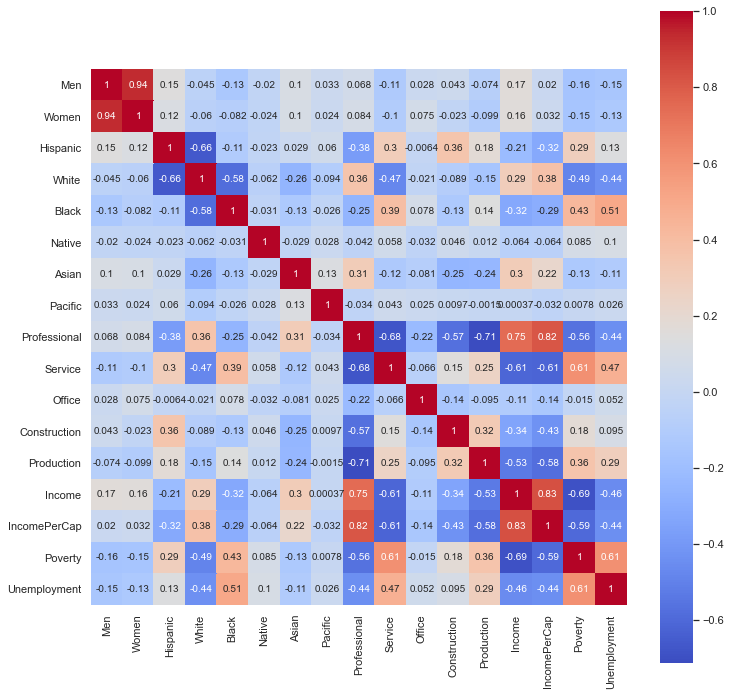

In [13]:
# Lets see how the categories for 'Men', 'Women', 'Hispanic', 'White',' Black', 'Native', 'Asian', 'Pacific', 'Income','IncomePerCap', 'Poverty', 'Unemployment' are related.

# correlation
plt.figure(figsize=(12,12))
sns.heatmap(usatop20states.corr(), annot=True, cmap="coolwarm", square=True)

Looking at the heatmap along with the correlation matrix we can identify a few highly correlated variables. For example, if you look at the correlation between birth_rate and pop_growth it ends up at almost .98. This is an extremely high correlation and marks it as a candidate to be removed. Logically it makes sense that these two are highly correlated; if you're having more babies, then the population should be increasing.

However, we should be more systematic in our approach to removing highly correlated variables. One method we can use is the variance_inflation_factor which is a measure of how much a particular variable is contributing to the standard error in the regression model. When significant multicollinearity exists, the variance inflation factor will be huge for the variables in the calculation.

A general recommendation is that if any of our variables come back with a value of 5 or higher, then they should be removed from the model. I decided to show you how the VFI comes out before we drop the highly correlated variables and after we remove the highly correlated variables. Going forward in the tutorial we will only be using the econ_df_after data frame.

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

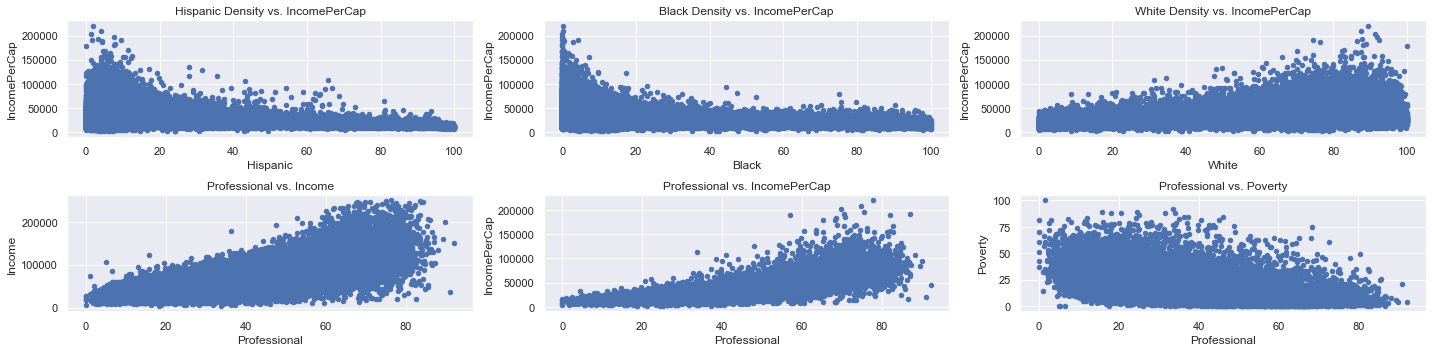

In [14]:
fig, axes = plt.subplots(nrows=2, ncols=3)
fig.set_figheight(5)
fig.set_figwidth(20)

usatop20states.plot(ax=axes[0,0],x='Hispanic', y='IncomePerCap', kind = 'scatter', title = 'Hispanic Density vs. IncomePerCap')
usatop20states.plot(ax=axes[0,1],x='Black', y='IncomePerCap', kind = 'scatter', title = 'Black Density vs. IncomePerCap')
usatop20states.plot(ax=axes[0,2],x='White', y='IncomePerCap', kind = 'scatter', title = 'White Density vs. IncomePerCap')
usatop20states.plot(ax=axes[1,0],x='Professional', y='Income', kind = 'scatter', title = 'Professional vs. Income')
usatop20states.plot(ax=axes[1,1], x='Professional', y='IncomePerCap', kind = 'scatter', title = 'Professional vs. IncomePerCap')
usatop20states.plot(ax=axes[1,2], x='Professional', y='Poverty', kind = 'scatter', title = 'Professional vs. Poverty')

c=np.array([0.5, 0.5, 0.5]).reshape(1,-1)

plt.tight_layout()

## Analysis

As we can see from this plot, there is a strong negative correlation between the fraction of white people in a state and the unemployment rate. Conversely, there is a strong positive correlation between the fraction of Hispanic and African Americans in a state and the unemployment rate. For Asians and Pacific Ocean, there is only a small correlation. For Native Americans, there is a moderatel sized negative correlation. Although this does not make sense (See for example US News article or Economic Policy Institute article), the key here is that this data only gives the net unemployment rate and the fraction of each ethnicity in for a state. This means that a state with reasonably low unemployment could actually have a relatively high amount of unemployment for a particular ethnic group.

Below I go through regression analysis on the data. However, the most important thing to point out is that regression is really describing the demographics of unemployment, not the relative unemployment for each ethnic group. For the latter, we would need the unemployment rate for each ethnic group in each state. Nevertheless, such an analysis can tell us whether certain ethnic groups tend to reside in states with high unemployment, which would provide motivation to do a more extensive study of the correlation of race and unemployment rate.

## Section 4: Describe the Data Set
Before we get to an in-depth exploration of the data or even building the model, we should explore the data a little more and see how the data is distributed and if there are any outliers. I will be adding a few more metrics to the summary data frame, sp that it now includes a metric for three standard deviations below and above the mean.

I'll store my information in a new variable called desc_df.

In [15]:
# get the summary
desc_df = usatop20states.describe()

# add the standard deviation metric
desc_df.loc['+3_std'] = desc_df.loc['mean'] + (desc_df.loc['std'] * 3)
desc_df.loc['-3_std'] = desc_df.loc['mean'] - (desc_df.loc['std'] * 3)

# display it
desc_df

,Men,Women,Hispanic,White,Black,Native,Asian,Pacific,Professional,Service,Office,Construction,Production,Income,IncomePerCap,Poverty,Unemployment
count,53398.000000,53398.000000,53398.000000,53398.000000,53398.000000,53398.000000,53398.000000,53398.000000,53398.000000,53398.000000,53398.000000,53398.000000,53398.000000,53398.000000,53398.000000,53398.000000,53398.000000
mean,2224.481685,2306.230889,18.502485,59.236940,13.808390,0.447067,5.471697,0.105328,35.922559,18.893824,23.476289,8.926422,12.781245,63226.695813,31485.910821,15.633645,7.270898
std,1121.063768,1146.714739,22.969476,30.907155,21.851603,3.322608,9.668184,0.529884,15.651873,8.100874,5.603675,5.995285,7.720660,31701.637756,16640.557661,12.125811,4.908810
min,26.000000,30.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3709.000000,1631.000000,0.000000,0.000000
25%,1475.000000,1536.000000,3.000000,33.800000,1.000000,0.000000,0.300000,0.000000,24.400000,13.200000,19.800000,4.700000,6.900000,41236.250000,20831.000000,6.600000,4.100000
50%,2062.000000,2147.000000,8.700000,67.400000,4.400000,0.000000,1.800000,0.000000,33.500000,17.800000,23.300000,8.000000,11.600000,56021.000000,27696.500000,12.300000,6.100000
75%,2764.000000,2865.000000,24.200000,86.500000,15.200000,0.300000,6.100000,0.000000,46.000000,23.400000,27.000000,12.000000,17.500000,77810.000000,37524.750000,21.300000,9.100000
max,32266.000000,33262.000000,100.000000,100.000000,100.000000,99.400000,91.400000,16.000000,92.200000,70.900000,58.100000,68.100000,60.500000,249750.000000,220253.000000,100.000000,56.500000
+3_std,5587.672989,5746.375105,87.410914,151.958404,79.363199,10.414892,34.476248,1.694981,82.878177,43.196445,40.287314,26.912276,35.943223,158331.609081,81407.583805,52.011078,21.997328
-3_std,-1138.709619,-1133.913328,-50.405943,-33.484525,-51.746419,-9.520758,-23.532854,-1.484325,-11.033059,-5.408797,6.665265,-9.059432,-10.380734,-31878.217456,-18435.762164,-20.743788,-7.455533


One thing that I want to mention is that we have only 50 observations, but 6 (minus the 3 we dropped) exploratory variables. Many people would argue that we need more data to have this many exploratory variables and to be honest, they are correct. Generally we should aim for at least 20 instances for each variable; however, some argue only 10 would do. Regardless, we will see at the end of our model that we only end up with 4 exploratory variables so that we will satisfy that rule.

Looking at the data frame up above, a few values are standing out, for example, the maximum value in the broad_money_growth column is almost four standard deviations above the mean. Such an enormous value would qualify as an outlier.

# Section Five: Build the Model

Okay, now that we've loaded, cleaned, and explored the data we can proceed to the next part, building the model. The first thing we need to do is, define our exploratory variables and our explanatory variable. From here, let's split the data into a training and testing set; a healthy ratio is 20% testing and 80% training but a 30% 70% split is also ok.

After splitting the data, we will create an instance of the linear regression model and pass through the X_train and y_train variables using the fit() function.

In [16]:
#let's split the data into a training and testing set; a healthy ratio is 20% testing and 80% training but a 30% 70% split is also ok.

#create test and trainning datasets
from sklearn.model_selection import train_test_split

# define our input variable (X) & output variable
X = usatop20states[['White', 'Professional']]
Y = usatop20states['IncomePerCap']

# Split X and y into X_
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=0)
x, y = usatop20states.iloc[:, 1:].values, usatop20states.iloc[:, 0].values

# create a Linear Regression model object
regression_model = LinearRegression()

# pass through the X_train & y_train data set
regression_model.fit(X_train, y_train)

LinearRegression()

# Getting Multiple Projections

We can also now make predictions with our newly trained model. The process is simple; we call the predict method and then pass through some values. In this case, we have some values predefined with the x_test variable so we will pass that through. Once we do that, we can select the predictions by slicing the array.

In [17]:
# Get multiple predictions
y_predict = regression_model.predict(X_test)

# Show the first 5 predictions
y_predict[:5]

array([36807.45741053, 28196.76579039, 16483.87790645, 42697.24717074,
       44466.38556017])

# Section 6: Evaluating the Model

To make diagnosing the model easier, we will, from this point forward, be using the statsmodel module. This module has built-in functions that will make calculating metrics quick. However, we will need "rebuild" our model using the statsmodel module. We do this by creating a constant variable, call the OLS() method and then the fit() method. We now have a new model, and the first thing we need to do is to make sure that the assumptions of our model hold. This means checking the following:

 - Regression residuals must be normally distributed.
 - The residuals are homoscedastic
 - Absence of multicollinearity (we did this above).
 - No Autocorrelation.

In [18]:
# define our intput
X2 = sm.add_constant(X)

# create a OLS model
model = sm.OLS(Y, X2)

# fit the data
est = model.fit()

# Checking for Heteroscedasticity
What is Heteroscedasticity?
One of the assumptions of our model is that there is no heteroscedasticity. What exactly does this mean? Well, to give a simple definition it merely means the standard errors of a variable, monitored over a specific amount of time, are non-constant. Let's imagine a situation where heteroscedasticity could exist.

Imagine we modeled household consumption based on income, something we would probably notice is how the variability of expenditures changes depending on how much income you have. In simple terms, we would see that households with more income spend money on a broader set of items compared to lower income households that would only be able to focus on the main staples. This results in standard errors that change over income levels.

What is the problem with heteroscedasticity?
There are two big reasons why you want homoscedasticity:

While heteroscedasticity does not cause bias in the coefficient estimates, it causes the coefficient estimates to be less precise. The Lower precision increases the likelihood that the coefficient estimates are further from the correct population value.

Heteroscedasticity tends to produce p-values that are smaller than they should be. This effect occurs because heteroscedasticity increases the variance of the coefficient estimates, but the OLS procedure does not detect this increase. Consequently, OLS calculates the t-values and F-values using an underestimated amount of variance. This problem can lead you to conclude that a model term is statistically significant when it is not significant.

How to test for heteroscedasticity?
To check for heteroscedasticity, we can leverage the statsmodels.stats.diagnostic module. This module will give us to a few test functions we can run, the Breusch-Pagan and the White test for heteroscedasticity. The Breusch-Pagan is a more general test for heteroscedasticity while the White test is a unique case.

The null hypothesis for both the White’s test and the Breusch-Pagan test is that the variances for the errors are equal:
H0 = σ2i = σ2
The alternate hypothesis (the one you’re testing), is that the variances are not equal:
H1 = σ2i ≠ σ2
Our goal is to fail to reject the null hypothesis, have a high p-value because that means we have no heteroscedasticity.


In [19]:
#Evaluating the Model: StatsModel1 (heteroscedasticity)

# Run the White's test

_, pval, __, f_pval = diag.het_white(est.resid, est.model.exog)
print(pval, f_pval)
print('-'*100)

# print the results of the test
if pval > 0.05:
    print("For the White's Test")
    print("The p-value was {:.4}".format(pval))
    print("We fail to reject the null hypthoesis, so there is no heterosecdasticity. \n")
    
else:
    print("For the White's Test")
    print("The p-value was {:.4}".format(pval))
    print("We reject the null hypthoesis, so there is heterosecdasticity. \n")

# Run the Breusch-Pagan test
_, pval, __, f_pval = diag.het_breuschpagan(est.resid, est.model.exog)
print(pval, f_pval)
print('-'*100)

# print the results of the test
if pval > 0.05:
    print("For the Breusch-Pagan's Test")
    print("The p-value was {:.4}".format(pval))
    print("We fail to reject the null hypthoesis, so there is no heterosecdasticity.")

else:
    print("For the Breusch-Pagan's Test")
    print("The p-value was {:.4}".format(pval))
    print("We reject the null hypthoesis, so there is heterosecdasticity.")

0.0 0.0
----------------------------------------------------------------------------------------------------
For the White's Test
The p-value was 0.0
We reject the null hypthoesis, so there is heterosecdasticity. 

0.0 0.0
----------------------------------------------------------------------------------------------------
For the Breusch-Pagan's Test
The p-value was 0.0
We reject the null hypthoesis, so there is heterosecdasticity.


# Checking for Autocorrelation
What is autocorrelation?
Autocorrelation is a characteristic of data in which the correlation between the values of the same variables is based on related objects. It violates the assumption of instance independence, which underlies most of conventional models.

When you have a series of numbers, and there is a pattern such that values in the series can be predicted based on preceding values in the series, the set of numbers is said to exhibit autocorrelation. This is also known as serial correlation and serial dependence. It generally exists in those types of data-sets in which the data, instead of being randomly selected, are from the same source.

What is the problem with autocorrelation?
The existence of autocorrelation means that computed standard errors, and consequently p-values, are misleading. Autocorrelation in the residuals of a model is also a sign that the model may be unsound. A workaround is we can compute more robust standard errors.

How to test for autocorrelation?
Again, we will go to our favorite module the statsmodels.stats.diagnostic module, and use the Ljung-Box test for no autocorrelation of residuals. Here:

H0: The data are random.
Ha: The data are not random.
That means we want to fail to reject the null hypothesis, have a large p-value because then it means we have no autocorrelation. To use the Ljung-Box test, we will call the acorr_ljungbox function, pass through the est.resid and then define the lags.

The lags can either be calculated by the function itself, or we can calculate them. If the function handles it the max lag will be min((num_obs // 2 - 2), 40), however, there is a rule of thumb that for non-seasonal time series the lag is min(10, (num_obs // 5)).

We also can visually check for autocorrelation by using the statsmodels.graphics module to plot a graph of the autocorrelation factor.

The number of lags will be 10
----------------------------------------------------------------------------------------------------
The lowest p-value found was 0.0
We reject the null hypthoesis, so there is autocorrelation.
----------------------------------------------------------------------------------------------------


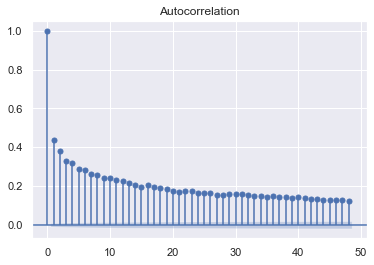

In [20]:
# test for autocorrelation
from statsmodels.stats.stattools import durbin_watson

# calculate the lag, optional
lag = min(10, (len(X)//5))
print('The number of lags will be {}'.format(lag))
print('-'*100)

# run the Ljung-Box test for no autocorrelation of residuals
# test_results = diag.acorr_breusch_godfrey(est, nlags = lag, store = True)
test_results = diag.acorr_ljungbox(est.resid, lags = lag)

# grab the p-values and the test statistics
ibvalue, p_val = test_results

# print the results of the test
if min(p_val) > 0.05:
    print("The lowest p-value found was {:.4}".format(min(p_val)))
    print("We fail to reject the null hypthoesis, so there is no autocorrelation.")
    print('-'*100)
else:
    print("The lowest p-value found was {:.4}".format(min(p_val)))
    print("We reject the null hypthoesis, so there is autocorrelation.")
    print('-'*100)

# plot autocorrelation
sm.graphics.tsa.plot_acf(est.resid)
plt.show()

# Checking For Normally Distributed Residuals
This one is easy to check for; we will do it visually. This will require using a QQ pplot which help us assess if a set of data plausibly came from some theoretical distribution such as a Normal or exponential. It’s just a visual check, not an air-tight proof, so it is somewhat subjective.

Visually what we are looking for is the data hugs the line tightly; this would give us confidence in our assumption that the residuals are normally distributed. Now, it is highly unlikely that the data will perfectly hug the line, so this is where we have to be subjective.

Checking the Mean of the Residuals Equals 0
Additionally, we need to check another assumption, that the mean of the residuals is equal to zero. If the mean is very close to zero, then we are good to proceed. Just a side note, it's not uncommon to get a mean that isn't exactly zero; this is because of rounding errors. However, if it's very close to zero, it's ok. In the example below, you will see that it doesn't come out exactly to zero.

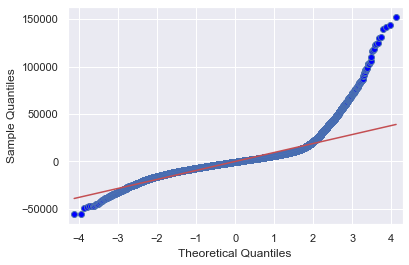

The mean of the residuals is 3.256e-11


In [21]:
import pylab

# check for the normality of the residuals
sm.qqplot(est.resid, line='s')
pylab.show()

# also check that the mean of the residuals is approx. 0.
mean_residuals = sum(est.resid)/ len(est.resid)
print("The mean of the residuals is {:.4}".format(mean_residuals))

# Measures of Error
We can examine how well our data fit the model, so we will take y_predictions and compare them to our y_actuals these will be our residuals. From here we can calculate a few metrics to help quantify how well our model fits the data. Here are a few popular metrics:

Mean Absolute Error (MAE): Is the mean of the absolute value of the errors. This gives an idea of magnitude but no sense of direction (too high or too low).

Mean Squared Error (MSE): Is the mean of the squared errors. MSE is more popular than MAE because MSE "punishes" more significant errors.

Root Mean Squared Error (RMSE): Is the square root of the mean of the squared errors. RMSE is even more favored because it allows us to interpret the output in y-units.

Luckily for us, sklearn and statsmodel both contain functions that will calculate these metrics for us. The examples below were calculated using the sklearn library and the math library.

In [22]:
import math
# calculate the mean squared error
model_mse = mean_squared_error(y_test, y_predict)

# calculate the mean absolute error
model_mae = mean_absolute_error(y_test, y_predict)

# calulcate the root mean squared error
model_rmse =  math.sqrt(model_mse)

# display the output
print("MSE {:.3}".format(model_mse))
print("MAE {:.3}".format(model_mae))
print("RMSE {:.3}".format(model_rmse))

MSE 8.91e+07
MAE 6.07e+03
RMSE 9.44e+03


# R-Squared
The R-Squared metric provides us a way to measure the goodness of fit or, in other words, how well our data fits the model. The higher the R-Squared metric, the better the data fit our model. However, one limitation is that R-Square increases as the number of features increase in our model, so if I keep adding variables even if they're poor choices R-Squared will still go up! A more popular metric is the adjusted R-Square which penalizes more complex models, or in other words models with more exploratory variables. In the example below, I calculate the regular R-Squared value, however, the statsmodel summary will calculate the Adjusted R-Squared below.

In [23]:
#The R-Squared metric provides us a way to measure the goodness of fit or, in other words, how well our data fits the model.

model_r2 = r2_score(y_test, y_predict)
print("R2: {:.2}".format(model_r2))

R2: 0.68


Our regression analysis shows a moderate effect (0.5 < R^2 < 0.75) of race and the unemployment rate in each state. The positive coefficients for African Americans and Hispanics reflect that these races tend to live in states with a high unemployment rate. Conversely, the substantial negative coefficient for Whites reflects that Whites predominently reside in states with lower unemployment rates.

# Confidence Intervals
Let's look at our confidence intervals. Keep in mind that by default confidence intervals are calculated using 95% intervals. We interpret confidence intervals by saying if the population from which this sample was drawn was sampled 100 times. Approximately 95 of those confidence intervals would contain the "true" coefficient.

Why do we provide a confidence range? Well, it comes from the fact that we only have a sample of the population, not the entire population itself. Because of this, it means that the "true" coefficient could exist in the interval below or it couldn't, but we cannot say for sure. We provide some uncertainty by providing a range, usually 95%, where the coefficient is probably in.

Want a narrower range? Decrease your confidence.
Want a wider range? Increase your confidence.

In [24]:
# make some confidence intervals, 95% by default
est.conf_int()

,0,1
const,-1648.054706,-1205.162785
White,46.759378,52.330033
Professional,829.007364,840.007525


Hypothesis Testing
With hypothesis testing, we are trying to determine the statistical significance of the coefficient estimates. This test is outlined as the following.

Null Hypothesis: There is no relationship between the exploratory variables and the explanatory variable.
Alternative Hypothesis: There is a relationship between the exploratory variables and the explanatory variable.
If we reject the null, we are saying there is a relationship, and the coefficients do not equal 0.
If we fail to reject the null, we are saying there is no relationship, and the coefficients do equal 0

In [25]:
# estimate the p-values
est.pvalues

const            1.693600e-36
White           2.395191e-263
Professional     0.000000e+00
dtype: float64

Here it's a little hard to tell, but we have a few insignificant coefficients. The first is the constant itself, so technically this should be dropped. However, we will see that once we remove the irrelevant variables that the intercept becomes significant. If it still wasn't significant, we could have our intercept start at 0 and assume that the cumulative effect of X on Y begins from the origin (0,0). Along with the constant, we have unemployment and broad_money_growth both come out as insignificant.

# Create a Summary of the Model Output
Let's create a summary of some of our keep metrics, sklearn does not have a good way of creating this output so we would have to calculate all the parameters ourselves. Let's avoid this and use the statsmodel.api library as we can create the same model we did up above, but we can also leverage the summary() method to create an output for us. Some of the metrics might differ slightly, but they generally should be the same.

In [26]:
# print out a summary
print(est.summary())

                            OLS Regression Results                            
Dep. Variable:           IncomePerCap   R-squared:                       0.677
Model:                            OLS   Adj. R-squared:                  0.677
Method:                 Least Squares   F-statistic:                 5.596e+04
Date:                Sun, 30 May 2021   Prob (F-statistic):               0.00
Time:                        09:51:56   Log-Likelihood:            -5.6460e+05
No. Observations:               53398   AIC:                         1.129e+06
Df Residuals:                   53395   BIC:                         1.129e+06
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const        -1426.6087    112.982    -12.627   

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
The first thing we notice is that the p-values from up above are now easier to read and we can now determine that the coefficients that have a p-value greater than 0.05 can be removed. We also have our 95% confidence interval (described up above), our coefficient estimates (described up above), the standard errors, and t-values.

The other metric that stands out is our Adjusted R-Squared value which is .878, lower than our R-Squared value. This makes sense as we were probably docked for the complexity of our model. However, an R-Squared over .878 is still very strong.

The only additional metrics we will describe here is the t-value which is the coefficient divided by the standard error. The higher the t-value, the more evidence we have to reject the null hypothesis. Also the standard error, the standard error is the approximate standard deviation of a statistical sample population.



# Trying other models

We will try pipeline, which make a compination between StandardScaler, polynomial and linear regression.

In [27]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

X = usatop20states[['White', 'Professional']]
Y = usatop20states['IncomePerCap']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=10)

model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

mean_squared_error(y_test, y_pred), mean_absolute_error(y_test, y_pred), r2_score(y_test, y_pred)

(1209964.3281790363, 802.90453548902, 0.008695500422889912)

## Polynomial Regression

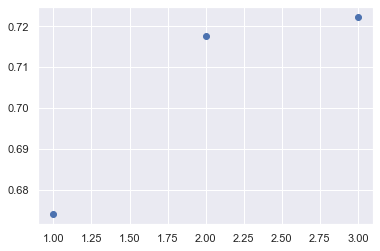

In [28]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import cross_val_score

def create_polynomial_regression_model(degree):
 poly_features = PolynomialFeatures(degree=degree)
 X_poly = poly_features.fit_transform(X)
 poly = LinearRegression()
 return np.mean(cross_val_score(poly, X_poly, Y, cv=5))
poly_cv = []
for i in range(1,4):
 poly_cv.append(create_polynomial_regression_model(i))
plt.scatter(range(1,4),poly_cv)

CV score for a 2nd degree polynomial is between 0.71 and 0.72

In [29]:
#Lasso Regression

from sklearn.linear_model import LassoCV
lasso = LassoCV(cv=5).fit(X, Y)
lasso.score(X, Y)

0.6769918049512826

Almost the same result as the model before.
We will try the Ridge model also.

We also got 0.83.

In [35]:
from sklearn.linear_model import RidgeCV
ridge = RidgeCV(cv=5).fit(X, Y)
ridge.score(X, Y)

0.6769924879525537

In [36]:
#Decision Tree

from sklearn.tree import DecisionTreeRegressor
dt = DecisionTreeRegressor()
np.mean(cross_val_score(dt, X, Y, cv=5))

0.40392443511343606

In [ ]:
# Random Forest

from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor()
np.mean(cross_val_score(rf, X, Y, cv=5))

We also got 0.83.

Conclusion: Different regression models were evaluated based on the CV scores and it’s observed that ridge/lasso regression best fits the data compared to all the other methods.
We can also observe that a perfect linear model is not a good approximation for the given data set.
The reason behind the performance of respective models for the given data can be further understood by looking at the relationship between the observed and target variables.

# Conclusion
The best R^2 we get is 0.84 which is very good estimation for Income. The model is poly(2) with linear regression. and we found that Income depend mostly on

## Conclusions
The purpose of this study was to examine the relationship between child poverty rates in New York City and a number of other variables collected by or derived from the 2010 United States Census using a limited dataset, and to explore the feasibility of predicting these rates in the absence of any household or per capita income data. Section 5 summarises the respective relationships, by category, that the census data variables had with child poverty rates. From the model creation, testing and evaluation it was concluded that:

- Via multiple imputation and boosted regression it was possible to model the estimated child poverty rates for census tracts in New York City without any household or personal income data.
- The model successfully predicted the condition of High Child Poverty (child poverty rates in the upper quartile of the city as a whole) with a minimum of 80% accuracy.
- The model successfully predicted the condition of Above Average Child Poverty (child poverty rates above the median of the city as a whole) with a minimum of 75% accuracy.
- When applied to census data for the same time period on the Chicago Metropolitan Area the model was similarly accurate albeit less so.
- For Chicago the model successfully predicted the condition of High Child Poverty (child poverty rates in the upper quartile of the city as a whole) with approximately 80% accuracy.
- For Chicago the model successfully predicted the condition of Above Average Child Poverty (child poverty rates above the median of the city as a whole) with approximately 75% accuracy.
- For both cities, when data on incomes was included model accuracy increased to between 90-95%.
- In the absence of data relating to household composition by age it may not be possible to predict child poverty rates with greater accuracy.
- Apart from measures of income, the most important predictor for child poverty rates was the proportion of residents employed in the service industry.
- Despite its strong correlation with child poverty rates, unemployment was not a major consideration for predictive models.
- The maps and other visualisations will hopefully be of use for communicating the geographical distribution of child poverty rates in New York and their associated relationships with other factors. The model is likely too inaccurate for practical or academic use, but may be employed along with other tools to gain a clearer picture of where high child poverty rates are likely to arise. The latter points above may be of use to local authorities wishing to address child poverty in a targeted fashion within their respective cities. One possible measure would be a form of public transport subsidy for registered workers in the service industry who have children, reducing the burden of childcare costs.

This project will continue to be revised throughout 2018 and any suggestions, corrections or questions are welcome.